# Azure Machine Learning

## Import/Upload an ONNX Model to Azure Machine Learning

### Define and Train Model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [37]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
inference_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Define the class labels for CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Define a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(16 * 16 * 16, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = self.fc(x)
        return x

model = SimpleCNN()

In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Train the model (briefly, for simplicity)
num_epochs = 10
for epoch in range(num_epochs):  # Just 10 epochs for demonstration
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 1.5905
Epoch 2, Loss: 0.8889
Epoch 3, Loss: 1.3586
Epoch 4, Loss: 1.0161
Epoch 5, Loss: 0.6202
Epoch 6, Loss: 0.6996
Epoch 7, Loss: 0.5391
Epoch 8, Loss: 1.2003
Epoch 9, Loss: 0.8063
Epoch 10, Loss: 0.7126


### Save and Load Model

In [9]:
# Save the trained model
torch.save(model.state_dict(), "artifacts/simple_cnn.pth")

In [10]:
# Load the saved model
model = SimpleCNN()
model.load_state_dict(torch.load("artifacts/simple_cnn.pth"))
model.eval()  # Set the model to evaluation mode

/var/folders/06/wdqtkk796gjfxfq9063zphx40000gn/T/ipykernel_86627/2863030715.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("artifacts/s

SimpleCNN(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=4096, out_features=10, bias=True)
)

### Test Inference

In [34]:
# Visualize the image
def imshow(img, label = None, predicted = None, classes = None):
    img = img / 2 + 0.5  # Denormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    if label is not None and predicted is not None and classes is not None:
        plt.title(f"Label: {classes[label]}\nPredicted: {classes[predicted]}")
    plt.show()

In [31]:
# Pick an image from the test dataset
test_image_index = 45
image, label = testset[test_image_index]

Predicted Label (Training Set): truck


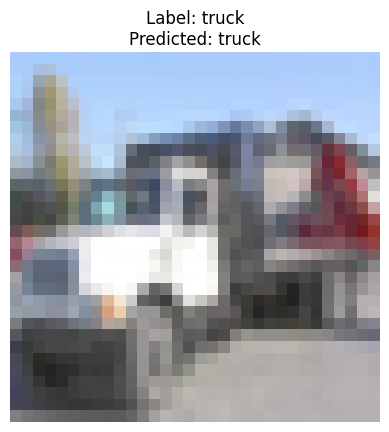

In [32]:
# Run inference on the training image
with torch.no_grad():
    train_inputs = image.unsqueeze(0)  # Add batch dimension
    train_outputs = model(train_inputs)
    _, predicted = torch.max(train_outputs, 1)

print(f"Predicted Label (Training Set): {classes[predicted.item()]}")
imshow(image, label, predicted.item(), classes)

### Export ONNX

In [33]:
# Define dummy input for ONNX export
dummy_input = torch.randn(1, 3, 32, 32)  # Batch size = 1, Image size = 32x32

# Export the model
onnx_file = "artifacts/simple_cnn.onnx"
torch.onnx.export(
    model, dummy_input, onnx_file,
    input_names=["input"], output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)
print(f"Model exported to {onnx_file}")

Model exported to artifacts/simple_cnn.onnx


### Load ONNX and RUn Inference

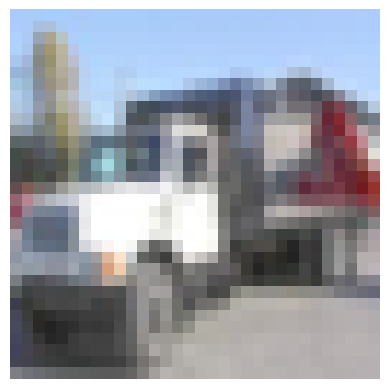

Predicted Label: truck


In [39]:
import numpy as np
import onnxruntime as ort
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Define class labels for CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Preprocessing function
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize to model input size
        transforms.ToTensor(),       # Convert to tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize to match training
    ])
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

# Pick an image from the test dataset
test_image_index = 45
image, label = inference_set[test_image_index]

# Load and preprocess an image
input_tensor = preprocess_image(image)

# Visualize the image
imshow(input_tensor.squeeze())

# Load the ONNX model
onnx_model_path = "artifacts/simple_cnn.onnx"  # Path to your ONNX model
ort_session = ort.InferenceSession(onnx_model_path)

# Prepare the input for ONNX Runtime
input_name = ort_session.get_inputs()[0].name  # Get input layer name
output_name = ort_session.get_outputs()[0].name  # Get output layer name

# Run inference
ort_inputs = {input_name: input_tensor.numpy()}
ort_outputs = ort_session.run([output_name], ort_inputs)

# Get predicted label
predicted_class = np.argmax(ort_outputs[0])
print(f"Predicted Label: {classes[predicted_class]}")

### Next Steps on Azure Machine Learning (Not All Tested)

Once the ONNX is created, we want to

- Upload it
- Deploy it
- Intereact with its Endpoint via REST.

Steps to upload the ONNX:

1.	Go to Azure Machine Learning Studio: Navigate to Models in your workspace.
2.	Upload the ONNX Model: Click `+ Register Model` and upload `artifacts/simple_cnn.onnx`.
3.	Use the Model: Use the ONNX model for inference, integration, or deployment in Azure ML Studio.

When the model is uploaded, we can deploy it: select it and click `Deploy`.

For the deployment, two things are necessary:

- A scoring script: `score.py`
- We need to select an environment; we can pick an existing one or generate a custom one.

Environments are basically defined with a `Dockefile` and an optional `requirements.txt` file.

Contents of a possible `score.py` generated by ChatGPT (untested):

```python
import json
import numpy as np
import onnxruntime as ort

def init():
    global model
    # Load the ONNX model
    model_path = "./model.onnx"  # Azure ML will map the model here
    model = ort.InferenceSession(model_path)

def run(raw_data):
    try:
        # Parse the input JSON
        input_data = np.array(json.loads(raw_data)["inputs"])

        # Perform inference
        input_name = model.get_inputs()[0].name
        output_name = model.get_outputs()[0].name
        result = model.run([output_name], {input_name: input_data})[0]

        # Return predictions as JSON
        return json.dumps({"predictions": result.tolist()})
    except Exception as e:
        return json.dumps({"error": str(e)})
```

Contents of `conda_onnx.yaml`:
acpt-pytorch-2.2-cuda12.1
```yaml
# Use Azure Machine Learning base image
FROM mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04

# Install additional Python packages
RUN pip install azureml-mlflow

```